## Generacion de Datos Historicos Coomproriente


In [3]:
pip install openpyxl

     -------------------------------------- 250.9/250.9 kB 5.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd

# Leer todas las hojas
sheets = pd.read_excel('../Datos_Precios/Lista de precios coomproriente.xlsx', sheet_name=None)

# Combinar todas las hojas en un solo DataFrame, agregando el nombre de la hoja como columna
df_all = pd.concat(
    [df.assign(PRODUCTO=sheet_name) for sheet_name, df in sheets.items()],
    ignore_index=True
)

df_all.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1240 entries, 0 to 1239
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   PRODUCTO  1240 non-null   object        
 1   PRECIO    1240 non-null   object        
 2   CANTIDAD  1240 non-null   object        
 3   FECHA     1240 non-null   datetime64[ns]
 4   ORIGEN    1240 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 48.6+ KB


In [5]:
df_all['FECHA'].unique()

<DatetimeArray>
['2025-03-20 00:00:00', '2025-03-26 00:00:00', '2025-03-27 00:00:00',
 '2025-03-31 00:00:00', '2025-04-02 00:00:00', '2025-04-03 00:00:00',
 '2025-04-07 00:00:00', '2025-04-09 00:00:00', '2025-04-10 00:00:00',
 '2025-04-14 00:00:00', '2025-04-21 00:00:00', '2025-04-23 00:00:00',
 '2025-04-24 00:00:00', '2025-04-28 00:00:00', '2025-04-30 00:00:00',
 '2025-05-05 00:00:00', '2025-05-08 00:00:00', '2025-03-19 00:00:00',
 '2025-05-07 00:00:00', '2025-03-17 00:00:00', '2025-03-13 00:00:00',
 '2025-03-12 00:00:00', '2025-03-10 00:00:00']
Length: 23, dtype: datetime64[ns]

In [6]:
productos=df_all['PRODUCTO'].unique()

## Generar datos sinteticos de cada uno de los productos desde enero hasta la ultima fecha


In [94]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Convertir PRECIO a numérico y FECHA a datetime
df_all['PRECIO'] = pd.to_numeric(df_all['PRECIO'], errors='coerce')
df_all['FECHA'] = pd.to_datetime(df_all['FECHA'], errors='coerce')

np.random.seed(42)

resultados = []

for producto in df_all['PRODUCTO'].unique():
    df_producto = df_all[df_all['PRODUCTO'] == producto].copy()
    df_producto = df_producto.dropna(subset=['PRECIO', 'FECHA'])
    if df_producto.empty:
        continue

    # Tomar la cantidad más frecuente o el primer valor no nulo
    cantidad = df_producto['CANTIDAD'].mode().iloc[0] if not df_producto['CANTIDAD'].mode().empty else df_producto['CANTIDAD'].iloc[0]

    # Agrupar por fecha y promediar precios si hay datos repetidos
    df_producto = df_producto.groupby('FECHA', as_index=False)['PRECIO'].mean()
    df_producto = df_producto.sort_values('FECHA').reset_index(drop=True)

    # Agregar índice para regresión
    df_producto['DIA'] = np.arange(len(df_producto))

    # Regresión lineal precio vs día
    X = df_producto['DIA'].values.reshape(-1, 1)
    modelo_precio = LinearRegression().fit(X, df_producto['PRECIO'].values)

    # Generar 20 días hacia atrás con regresión
    dias_pasado = np.arange(-20, 0).reshape(-1, 1)
    precios_pasado = modelo_precio.predict(dias_pasado)

    primer_dia = df_producto['FECHA'].min()
    fechas_pasado = [primer_dia - pd.Timedelta(days=i) for i in range(20, 0, -1)]

    df_pasado = pd.DataFrame({
        'FECHA': fechas_pasado,
        'PRECIO': precios_pasado.round(2)
    })

    # Unir datos pasados y reales
    df_completo = pd.concat([df_pasado, df_producto[['FECHA', 'PRECIO']]], ignore_index=True).sort_values('FECHA').reset_index(drop=True)

    # Establecer límite máximo de fecha
    fecha_final = pd.to_datetime("2025-05-16")
    total_dias = (fecha_final - df_completo['FECHA'].min()).days + 1
    fechas_totales = pd.date_range(start=df_completo['FECHA'].min(), end=fecha_final, freq='D')

    # Reindexar e interpolar precios faltantes
    df_reindex = df_completo.set_index('FECHA').reindex(fechas_totales)
    df_reindex['PRECIO'] = df_reindex['PRECIO'].interpolate(method='linear').ffill().bfill()

    # Agregar ruido al precio para datos sintéticos (con mínimo de 1.0)
    ruido_precio = np.random.normal(loc=0, scale=2, size=len(df_reindex))
    precio_sintetico = df_reindex['PRECIO'] + ruido_precio
    precio_sintetico = np.where(precio_sintetico < 1.0, 1.0, precio_sintetico)
    df_reindex['PRECIO_SINTETICO'] = np.round(precio_sintetico, 2)

    # Cantidad fija
    df_reindex['CANTIDAD'] = cantidad
    df_reindex['PRODUCTO'] = producto
    df_reindex = df_reindex.reset_index().rename(columns={'index': 'FECHA'})

    df_final = df_reindex[['FECHA', 'PRODUCTO', 'PRECIO_SINTETICO', 'CANTIDAD']]

    resultados.append(df_final)

# Concatenar todos los productos
df_sintetico_final = pd.concat(resultados, ignore_index=True)

# Guardar CSV
df_sintetico_final.to_csv('../Datos_Precios/precios_cantidad_sinteticos_fijos.csv', index=False)

# Mostrar primeros registros e info
print(df_sintetico_final.head())
print(df_sintetico_final.info())


       FECHA     PRODUCTO  PRECIO_SINTETICO          CANTIDAD
0 2025-02-18  Sandia Baby              3.48  Kilogramo - 1 Kg
1 2025-02-19  Sandia Baby              2.20  Kilogramo - 1 Kg
2 2025-02-20  Sandia Baby              3.78  Kilogramo - 1 Kg
3 2025-02-21  Sandia Baby              5.52  Kilogramo - 1 Kg
4 2025-02-22  Sandia Baby              2.00  Kilogramo - 1 Kg
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4960 entries, 0 to 4959
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   FECHA             4960 non-null   datetime64[ns]
 1   PRODUCTO          4960 non-null   object        
 2   PRECIO_SINTETICO  4960 non-null   float64       
 3   CANTIDAD          4960 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 155.1+ KB
None


In [95]:
df_producto['FECHA'].max()

Timestamp('2025-05-08 00:00:00')

# Prophet para la prediccion de historicos

## Prediccion de precios para 7 dias

In [96]:
from prophet import Prophet
import pandas as pd
import numpy as np



resultados_pred = []

for producto in df_sintetico_final['PRODUCTO'].unique():
    df_producto = df_sintetico_final[df_sintetico_final['PRODUCTO'] == producto].copy()
    df_producto = df_producto.dropna(subset=['PRECIO_SINTETICO', 'FECHA'])
    if len(df_producto) < 5:  # si hay pocos datos, salta
        continue

    # Prophet requiere columnas 'ds' y 'y'
    df_producto = df_producto.groupby('FECHA', as_index=False)['PRECIO_SINTETICO'].mean()
    df_producto.rename(columns={'FECHA': 'ds', 'PRECIO_SINTETICO': 'y'}, inplace=True)

    model = Prophet(daily_seasonality=True)
    model.fit(df_producto)

    # Crear dataframe futuro para 7 días
    future = model.make_future_dataframe(periods=7)

    forecast = model.predict(future)

    # Extraer fechas y predicción
    df_forecast = forecast[['ds', 'yhat']].tail(7)
    df_forecast['PRODUCTO'] = producto

    # Para mantener el formato
    df_forecast.rename(columns={'ds': 'FECHA', 'yhat': 'PRECIO_PREDICTO'}, inplace=True)

    resultados_pred.append(df_forecast)

df_pred_final = pd.concat(resultados_pred, ignore_index=True)

print(df_pred_final.head())


17:33:41 - cmdstanpy - INFO - Chain [1] start processing
17:33:41 - cmdstanpy - INFO - Chain [1] done processing
17:33:41 - cmdstanpy - INFO - Chain [1] start processing
17:33:41 - cmdstanpy - INFO - Chain [1] done processing
17:33:42 - cmdstanpy - INFO - Chain [1] start processing
17:33:42 - cmdstanpy - INFO - Chain [1] done processing
17:33:42 - cmdstanpy - INFO - Chain [1] start processing
17:33:43 - cmdstanpy - INFO - Chain [1] done processing
17:33:43 - cmdstanpy - INFO - Chain [1] start processing
17:33:43 - cmdstanpy - INFO - Chain [1] done processing
17:33:44 - cmdstanpy - INFO - Chain [1] start processing
17:33:44 - cmdstanpy - INFO - Chain [1] done processing
17:33:44 - cmdstanpy - INFO - Chain [1] start processing
17:33:44 - cmdstanpy - INFO - Chain [1] done processing
17:33:45 - cmdstanpy - INFO - Chain [1] start processing
17:33:45 - cmdstanpy - INFO - Chain [1] done processing
17:33:45 - cmdstanpy - INFO - Chain [1] start processing
17:33:45 - cmdstanpy - INFO - Chain [1]

       FECHA  PRECIO_PREDICTO     PRODUCTO
0 2025-05-17         2.370497  Sandia Baby
1 2025-05-18         3.013829  Sandia Baby
2 2025-05-19         2.966335  Sandia Baby
3 2025-05-20         1.836562  Sandia Baby
4 2025-05-21         2.524252  Sandia Baby


In [97]:
df_pred_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   FECHA            434 non-null    datetime64[ns]
 1   PRECIO_PREDICTO  434 non-null    float64       
 2   PRODUCTO         434 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 10.3+ KB


In [98]:
df_sintetico_final.sort_values('FECHA', inplace=True)
df_sintetico_final.iloc[-1]


FECHA               2025-05-16 00:00:00
PRODUCTO             Arracacha Amarilla
PRECIO_SINTETICO                 131.01
CANTIDAD                  Bulto - 50 Kg
Name: 4959, dtype: object

In [99]:
df_pred_final.sort_values('FECHA', inplace=True)
df_pred_final.iloc[0]

FECHA              2025-05-17 00:00:00
PRECIO_PREDICTO               2.370497
PRODUCTO                   Sandia Baby
Name: 0, dtype: object

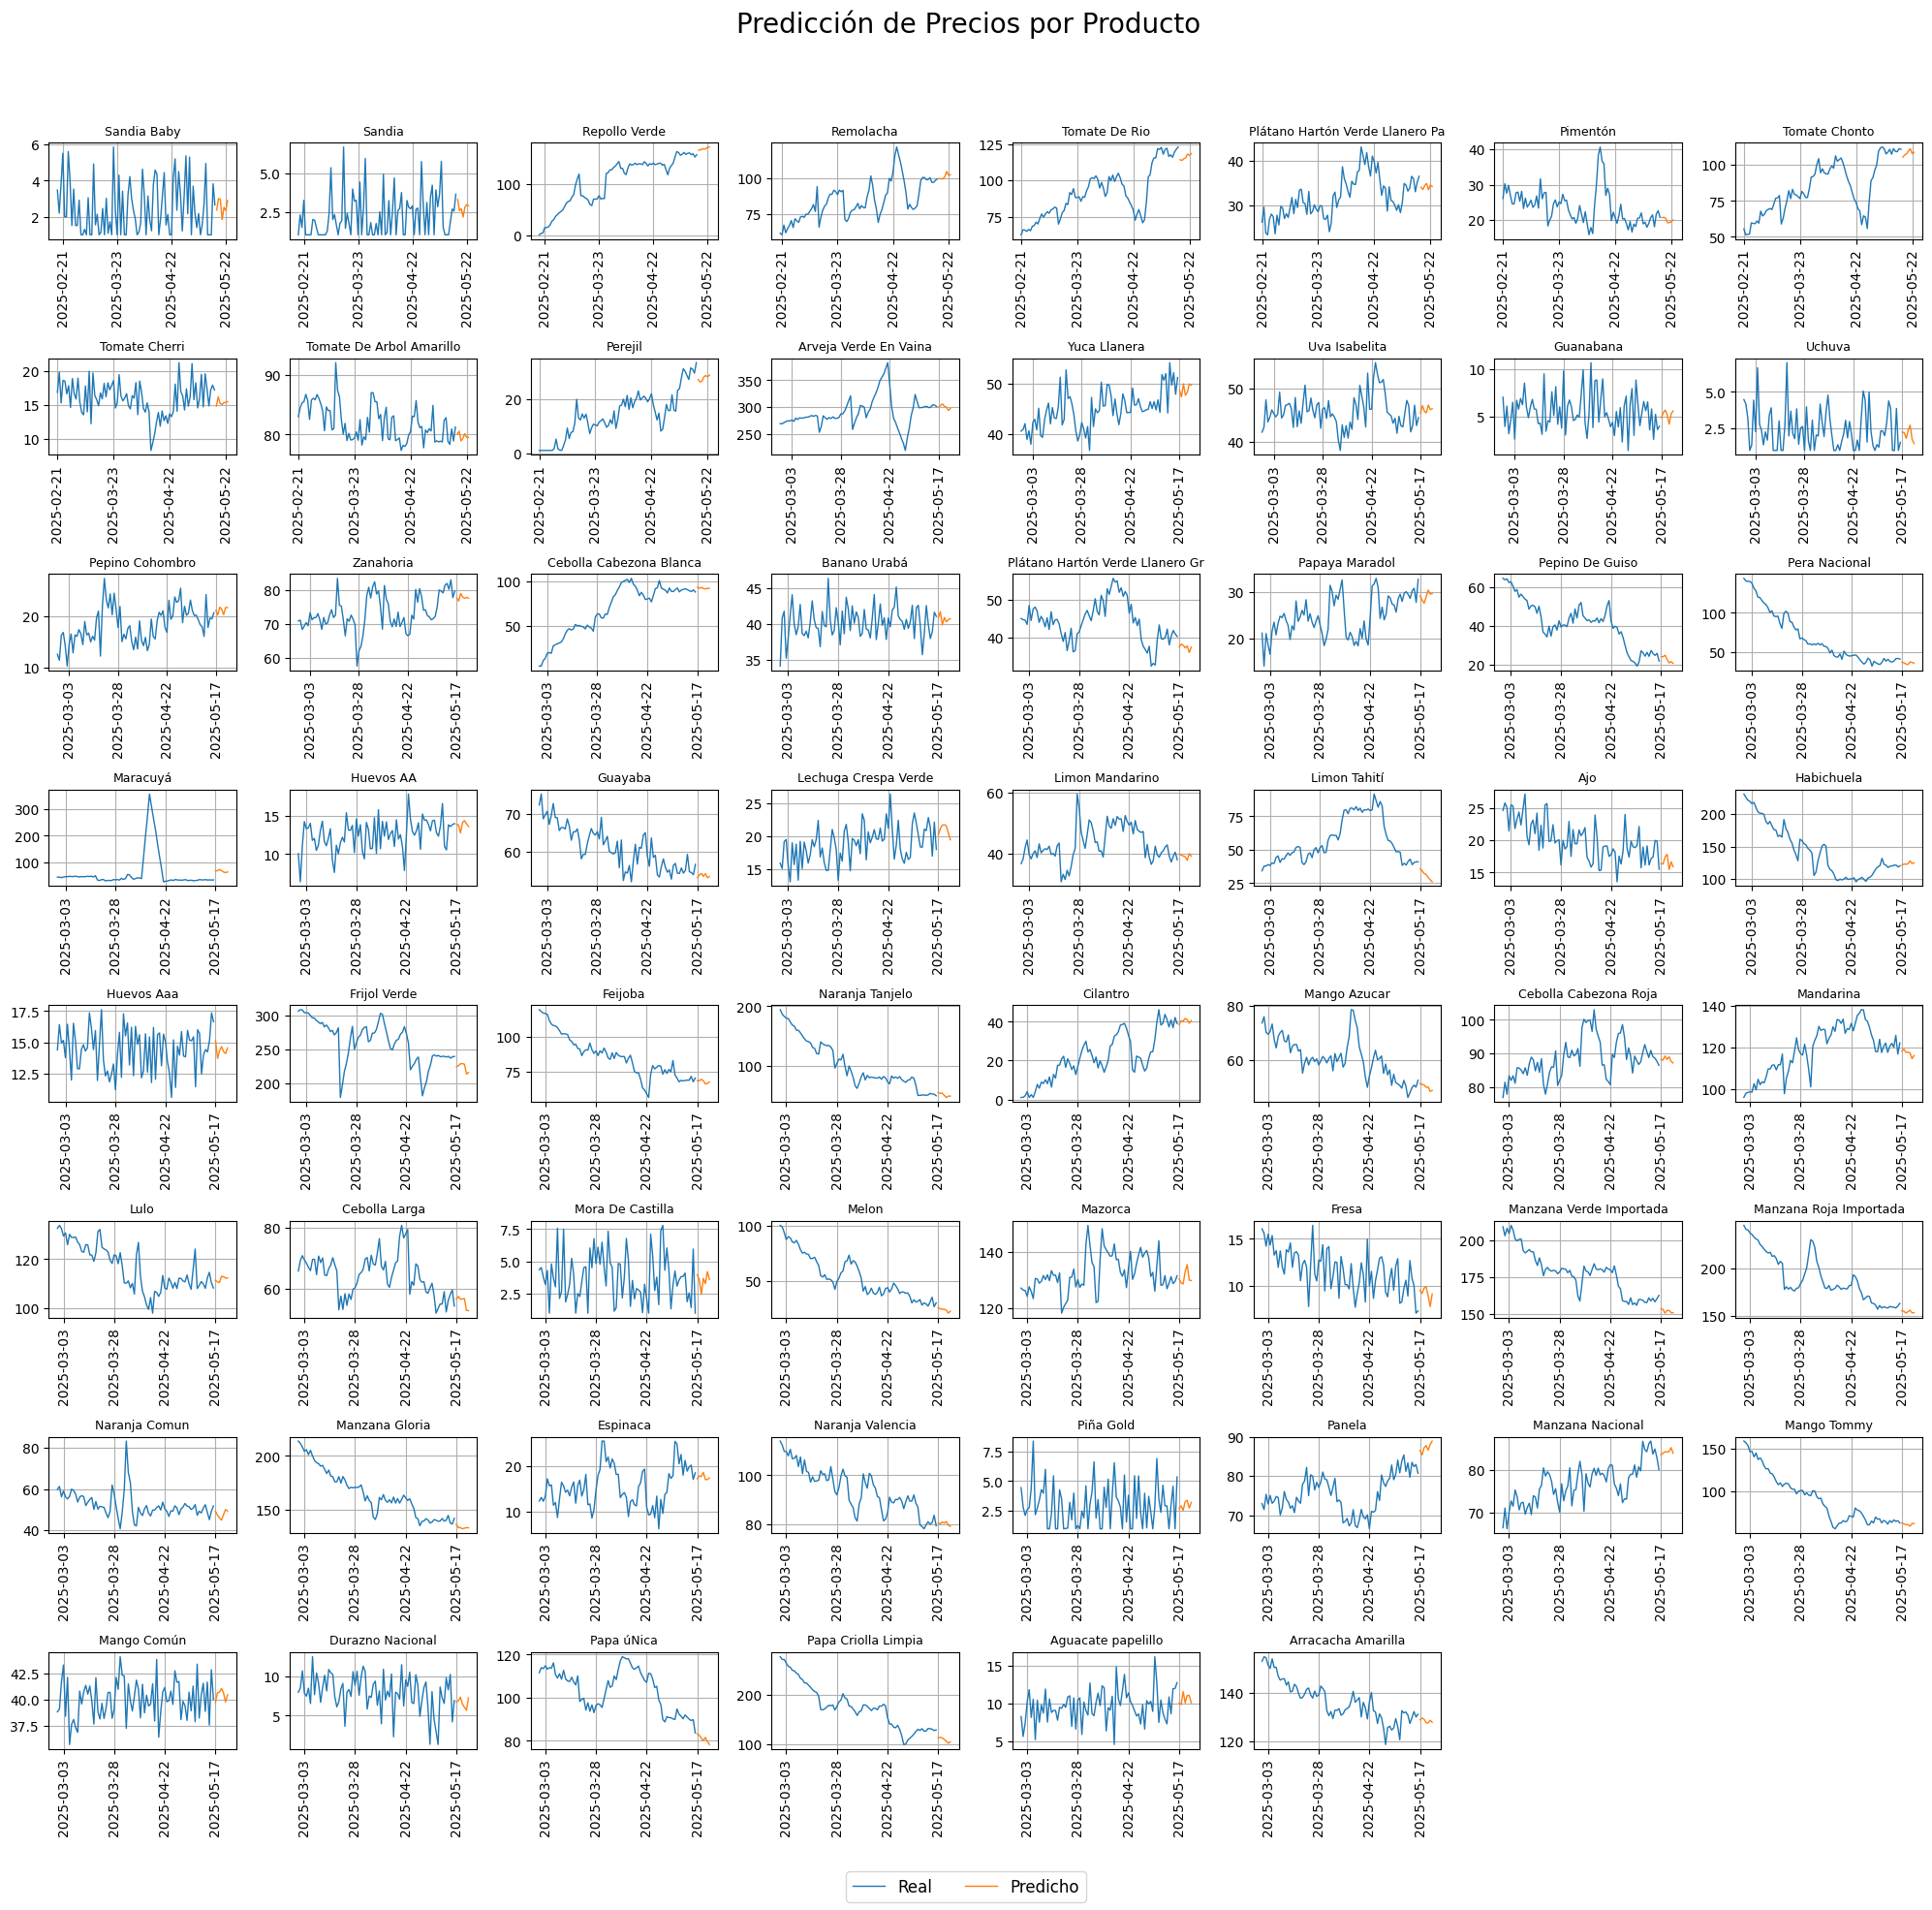

In [100]:
import matplotlib.pyplot as plt
import numpy as np

productos = df_all['PRODUCTO'].unique()
num_productos = len(productos)
plots_por_figura = 64  # 8x8
filas, columnas = 8, 8

for i in range(0, num_productos, plots_por_figura):
    fig, axes = plt.subplots(filas, columnas, figsize=(20, 20))
    fig.suptitle('Predicción de Precios por Producto', fontsize=20)
    axes = axes.flatten()

    for j, producto in enumerate(productos[i:i + plots_por_figura]):
        ax = axes[j]
        df_grouped = df_sintetico_final[df_sintetico_final['PRODUCTO'] == producto].copy()
        df_pred_grouped = df_pred_final[df_pred_final['PRODUCTO'] == producto].copy()

        df_grouped = df_grouped.sort_values('FECHA')
        df_pred_grouped = df_pred_grouped.sort_values('FECHA')

        ax.plot(df_grouped['FECHA'], df_grouped['PRECIO_SINTETICO'], label='Real', linewidth=1)
        ax.plot(df_pred_grouped['FECHA'], df_pred_grouped['PRECIO_PREDICTO'], label='Predicho', linewidth=1)
        ax.set_title(producto, fontsize=9)
        ax.tick_params(axis='x', labelrotation=90)
        ax.grid(True)
        
        # Opcional: reducir cantidad de ticks para claridad
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))

    # Desactivar subplots sobrantes si no se usan todos
    for k in range(j + 1, plots_por_figura):
        fig.delaxes(axes[k])

    # Agregar leyenda general
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



In [101]:
df_pred_final.to_csv('../Datos_Precios/precios_cantidad_predichos_prophet.csv', index=False)

